# Import Libraries

In [241]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast
import re

# Load Dataset

In [207]:
games = pd.read_csv('../data/games_clean.csv')

In [208]:
games['Release date'] = pd.to_datetime(games['Release date'])

# Feature Engineering

## Functions

In [209]:
def scores_class(features : pd.DataFrame, target : pd.Series, discrete_features : str):
  score_classify = mutual_info_classif(features, target, discrete_features=discrete_features)
  scores = pd.DataFrame({
    'Feature': features.columns,
    'MI Score (Classify)': score_classify
  })
  return scores.sort_values(by = 'MI Score (Classify)', ascending = False)

def count_languages(word : str):
  word.replace("'", '')
  word.replace("[", '').replace("]", '')
  return len(word.split(','))

## Encode - Feature Categorical

In [210]:
categories = []
for i, row in games.iterrows():
    if type(row['Genres'].split(',')) == list:
        for cat in row['Genres'].split(','): categories.append(cat)

print(len(set(categories)))

33


In [211]:
one_hot_encode = pd.DataFrame()

for category in set(categories):
    cat = []
    for _, row in games.iterrows():
        cat.append(np.int64(category in row['Genres'].split(',')))
    one_hot_encode[category] = cat

one_hot_encode.head()

,Episodic,Utilities,Photo Editing,360 Video,Sports,Documentary,Education,Design & Illustration,Casual,Violent,...,Software Training,Early Access,Accounting,Racing,Adventure,Simulation,Indie,Nudity,RPG,Movie
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [212]:
games = pd.concat((games, one_hot_encode), axis = 1)

In [213]:
games = games.drop(columns= ['Genres'])

In [214]:
ordinal_cols = ['Estimated owners']

In [215]:
mappings = [
    {
        'col' : 'Estimated owners',
        'mapping' : {
            '0 - 0'                 : 0,
            '0 - 20000'             : 1,
            '20000 - 50000'         : 2,
            '50000 - 100000'        : 3,
            '100000 - 200000'       : 4,
            '200000 - 500000'       : 5,
            '500000 - 1000000'      : 6,
            '1000000 - 2000000'     : 7,
            '2000000 - 5000000'     : 8,
            '5000000 - 10000000'    : 9,
            '10000000 - 20000000'   : 10,
            '20000000 - 50000000'   : 11,
            '50000000 - 100000000'  : 12,
            '100000000 - 200000000' : 13
        }
    }
]

In [216]:
ordinal_enc = OrdinalEncoder(cols = ordinal_cols, mapping= mappings)

In [217]:
games = ordinal_enc.fit_transform(games)

## New Features

In [218]:
games['Platform_count'] = games[['Windows', 'Mac', 'Linux']].sum(axis = 1)

In [219]:
games['Achievements_per_hour'] = games.apply(
    lambda x : 
        x['Achievements'] 
        if x['Average playtime forever'] == 0 
        else x['Achievements'] / x['Average playtime forever'],
    axis = 1
)

In [220]:
games['Genre_count'] = games[list(set(categories))].sum(axis = 1)

In [221]:
games['Recent_playtime_ratio'] = games.apply(
    lambda x : 
        x['Average playtime two weeks'] 
        if x['Average playtime forever'] == 0 
        else x['Average playtime two weeks'] / x['Average playtime forever'],
    axis = 1
)

In [222]:
games['Language_count'] = games['Supported languages'].apply(count_languages)

In [223]:
games['OS_ratio'] = games[['Windows', 'Mac', 'Linux']].sum(axis = 1) / 3

In [224]:
games['Antiquity'] = (pd.to_datetime('today') - games['Release date']).dt.days

### Clustering

In [225]:
features = games[list(games.select_dtypes(include = 'number').columns)]

In [226]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters = 3, random_state= 42)
games['Cluster'] = kmeans.fit_predict(features_scaled)

C:\Users\HP\AppData\Local\Temp\ipykernel_19500\3976155345.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'Cluster', y = 'Price', data = games, palette = 'pastel')


<Axes: xlabel='Cluster', ylabel='Price'>

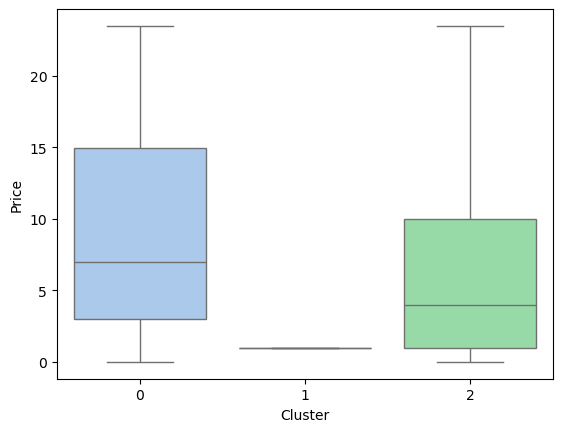

In [227]:
sns.boxplot(x = 'Cluster', y = 'Price', data = games, palette = 'pastel')

### Mutual Information

In [228]:
features = games.drop(columns=['Estimated owners', 'Release date', 'Supported languages'])
target = games['Estimated owners']

In [229]:
scores = scores_class(features, target, discrete_features = 'auto')

In [230]:
drop_columns = scores[scores['MI Score (Classify)'] < 0.01]

In [231]:
games.drop(columns = drop_columns['Feature'].values, inplace = True)

### PCA

In [232]:
features = games[games.select_dtypes(include = 'number').columns]

In [239]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create PCA object
pca = PCA(n_components = 5)
principal_components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

pca_df = pd.concat([pca_df, games[['Estimated owners']]], axis=1)

In [240]:
pca.explained_variance_ratio_

array([0.15412046, 0.1159463 , 0.09980874, 0.07652521, 0.07423593,
       0.07045361])

In [235]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,Estimated owners
0,0.197985,0.265933,0.028763,-0.918563,0.466334,1
1,0.900746,1.699968,-0.879967,0.564626,-0.222953,1
2,-0.861932,-0.759040,0.168772,0.197418,-0.189326,1
3,1.246381,2.627537,-1.532022,2.230349,-0.567823,1
4,-0.136971,0.525480,-0.532572,0.569249,-0.206240,1
